In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "drive/My Drive/Colab Notebooks/data"

GoogleNews-vectors-negative300.bin     news_proc_12_3_19.pickle
GoogleNews-vectors-negative300.bin.gz  vectors.zip


In [5]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


# Imports, loads , Train/test split and Optimum params
---

In [6]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn-v0_8')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
data = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

In [8]:
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

truth - [1]
fake - [0]


In [9]:
data['label'] = data.apply(lambda r: 1 if r['one_hot_label'][-1] == 1 else 0,axis=1)

In [10]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1590
Max len title: 13


In [19]:
#!/bin/bash
!curl -L -o "drive/My Drive/Colab Notebooks/data/vectors.zip" https://www.kaggle.com/api/v1/datasets/download/leadbest/googlenewsvectorsnegative300

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3250M  100 3250M    0     0  60.7M      0  0:00:53  0:00:53 --:--:-- 61.3M


In [20]:
!unzip "drive/My Drive/Colab Notebooks/data/vectors.zip" -d "drive/My Drive/Colab Notebooks/data"

Archive:  drive/My Drive/Colab Notebooks/data/vectors.zip
  inflating: drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin  
  inflating: drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz  


In [11]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin", binary=True, limit=50000)

In [12]:
embed_mat = np.zeros((50000,300))
for i, e in model.key_to_index.items():
    embed_mat[e] = model[i]

### Train/valid/test split

In [13]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [14]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [15]:
train_fit = [np.asarray(X_train_title.tolist()),
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()),
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()),
             np.asarray(X_test_content.tolist())]

In [16]:
del data
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

## Optimum Params found with Bayesian Optimization

In [17]:
params_cnn = {
    'lr': 0.2165058962234678,
    'momentum': 0.17315207003770283,
    'dropout1': 0.03535823654126957,
    'dropout2': 0.34342621903381093,
    'filters1Title': 10,
    'denseTitle': 58,
    'filtersContent': 10,
    'denseContent': 57
}

## CNN

In [18]:
#Some imports...
# import tensorflow as tf
import os

from numpy.random import seed

In [ ]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000,
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50001,
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
#

x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='sigmoid')(x)


#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

#model.compile(k.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='categorical_crossentropy', metrics=['acc'])
model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title_input (InputLayer)  │ (None, 13)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ content_input             │ (None, 1590)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embed_title (Embedding)   │ (None, 13, 300)        │     15,000,000 │ title_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embed_content (Embedding) │ (None, 1590, 300)      │     15,000,000 │ content_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1Title (Conv1D)       │ (None, 5, 5)           │          6,005 │ embed_title[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2Content (Conv1D)     │ (None, 394, 80)        │        384,080 │ embed_content[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool1Title (MaxPooling1D) │ (None, 2, 5)           │              0 │ Conv1Title[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool2Content              │ (None, 98, 80)         │              0 │ Conv2Content[0][0]     │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 10)             │              0 │ Pool1Title[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 7840)           │              0 │ Pool2Content[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1Title (Dense)       │ (None, 50)             │            550 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense1Content (Dense)     │ (None, 100)            │        784,100 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 150)            │              0 │ Dense1Title[0][0],     │
│                           │                        │                │ Dense1Content[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50)             │          7,550 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50)             │          2,550 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             51 │ dropout_1[0][0]        │
└──────────────────────

 Total params: 31,184,886 (118.96 MB)

 Trainable params: 1,184,886 (4.52 MB)

 Non-trainable params: 30,000,000 (114.44 MB)

In [20]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.1)], validation_data=(valid_fit, np.array(y_valid.tolist())))

Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - acc: 0.8790 - loss: 0.5442 - val_acc: 0.9222 - val_loss: 0.2008
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - acc: 0.9526 - loss: 0.1411 - val_acc: 0.9469 - val_loss: 0.1527
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - acc: 0.9716 - loss: 0.1041 - val_acc: 0.9415 - val_loss: 0.2001
Epoch 4/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - acc: 0.9829 - loss: 0.0738 - val_acc: 0.9454 - val_loss: 0.1787


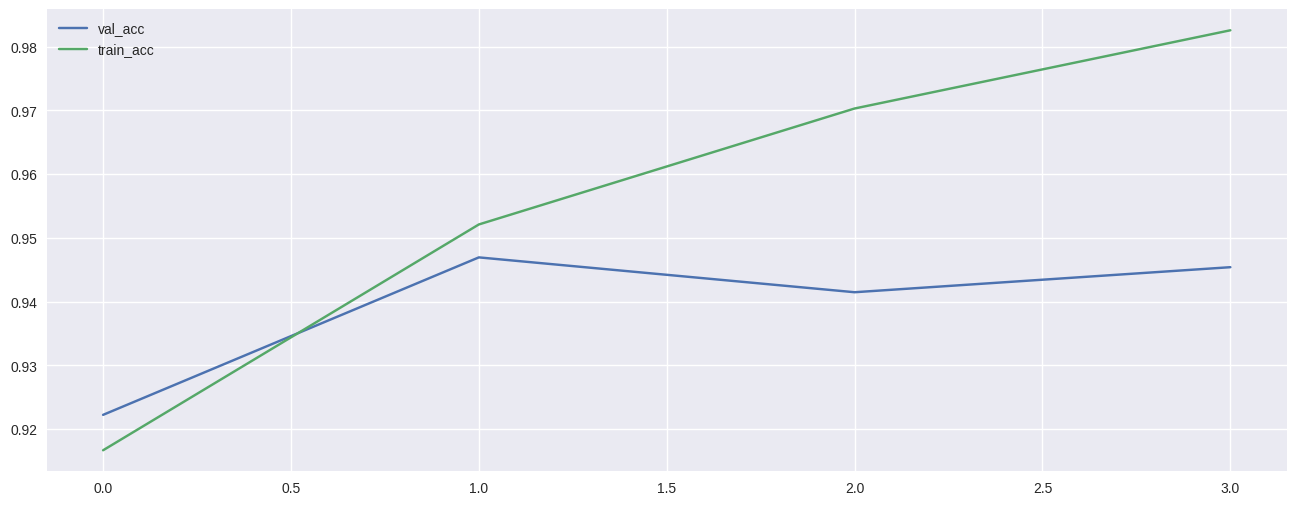

In [21]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

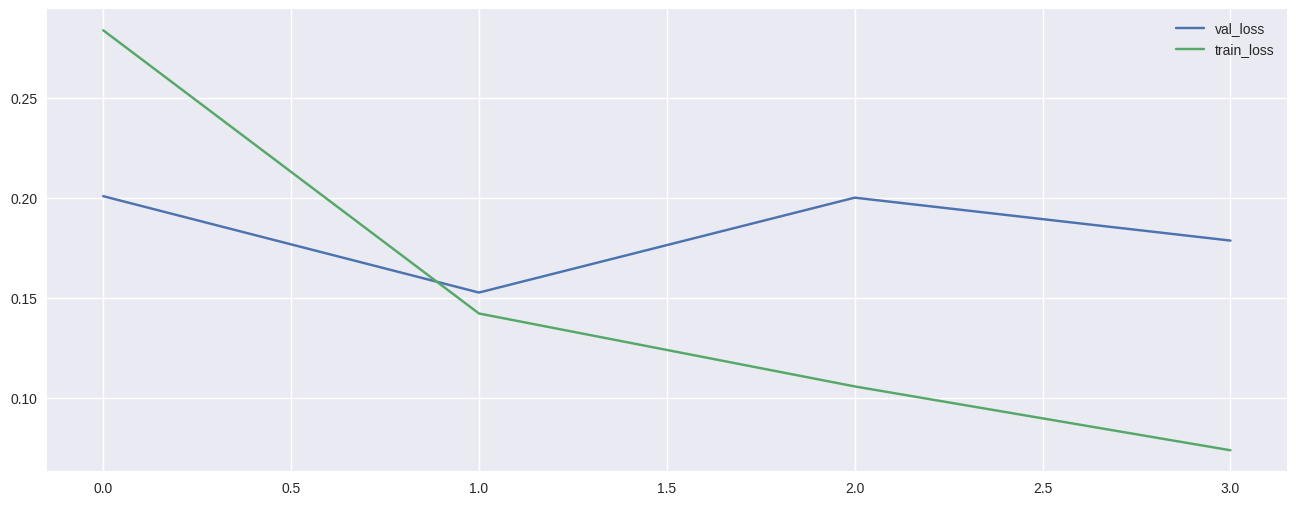

In [22]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [23]:
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

1103/1103 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


0.9463283243549759

In [24]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     17258
           1       0.93      0.97      0.95     18012

    accuracy                           0.95     35270
   macro avg       0.95      0.95      0.95     35270
weighted avg       0.95      0.95      0.95     35270



[[15873  1385]
 [  508 17504]]


<Axes: >

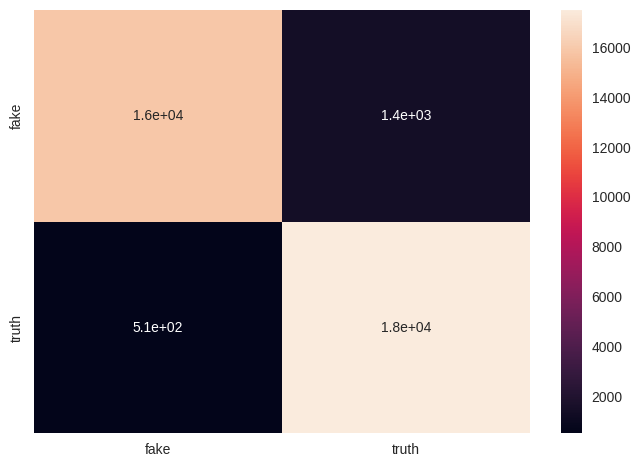

In [25]:
matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['fake', 'truth'], index=['fake', 'truth'])
sns.heatmap(df_cm, annot=True)

In [26]:
from sklearn import metrics

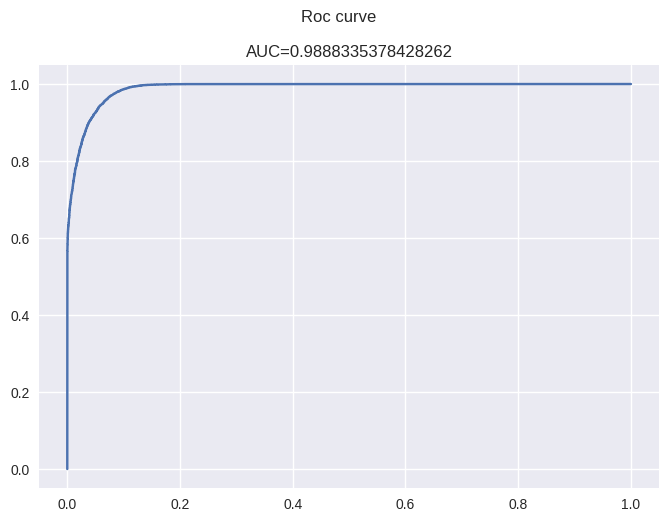

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [28]:
CONV_PATH = 'drive/My Drive/Colab Notebooks/weights/conv-binary.h5'
model.save(CONV_PATH)